In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Activation,Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,  Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import models

In [2]:
data_path = Path(f"Data")
train_path = data_path / 'train'
test_path = data_path / "test"
val_path = data_path / "valid"

print(os.listdir(data_path))

['test', 'train', 'valid']


In [3]:
# View data in a Data Frame
from data_utils import load_data, append_labeled_image
from visualization import plot
train_df = load_data(train_path, data = "train")
test_df = load_data(test_path, data = "test")
val_df = load_data(val_path, data = "validation")

['test', 'train', 'valid']


In [4]:
print(f"Shape of the Train Dataframe = {train_df.shape}")
print(train_df.head())

Shape of the Train Dataframe = (601, 2)
                                              images                    label
0  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
1  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
2  Data\train\squamous.cell.carcinoma_left.hilum_...  Squamous cell carcinoma
3  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma
4  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma


In [5]:
print(f"Shape of the Test Dataframe = {train_df.shape}")
print(train_df.head())

Shape of the Test Dataframe = (601, 2)
                                              images                    label
0  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
1  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
2  Data\train\squamous.cell.carcinoma_left.hilum_...  Squamous cell carcinoma
3  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma
4  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma


In [6]:
print(f"Shape of the Validation Dataframe = {train_df.shape}")
print(train_df.head())

Shape of the Validation Dataframe = (601, 2)
                                              images                    label
0  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
1  Data\train\adenocarcinoma_left.lower.lobe_T2_N...           Adenocarcinoma
2  Data\train\squamous.cell.carcinoma_left.hilum_...  Squamous cell carcinoma
3  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma
4  Data\train\large.cell.carcinoma_left.hilum_T2_...     Large cell carcinoma


In [7]:
train_df.dtypes

images    object
label     object
dtype: object

In [8]:
train_df["label"] = train_df["label"].astype("category")

print(train_df.dtypes)
# Convert object to category help saving memmory and grouping intuitivity


images      object
label     category
dtype: object


In [9]:
# View cancer case by categories
print(f"Unique Cancer Cases {train_df['label'].unique()}")

print(train_df['label'].value_counts())


Unique Cancer Cases ['Adenocarcinoma', 'Squamous cell carcinoma', 'Large cell carcinoma', 'Normal']
Categories (4, object): ['Adenocarcinoma', 'Large cell carcinoma', 'Normal', 'Squamous cell carcinoma']
label
Adenocarcinoma             195
Squamous cell carcinoma    155
Normal                     136
Large cell carcinoma       115
Name: count, dtype: int64


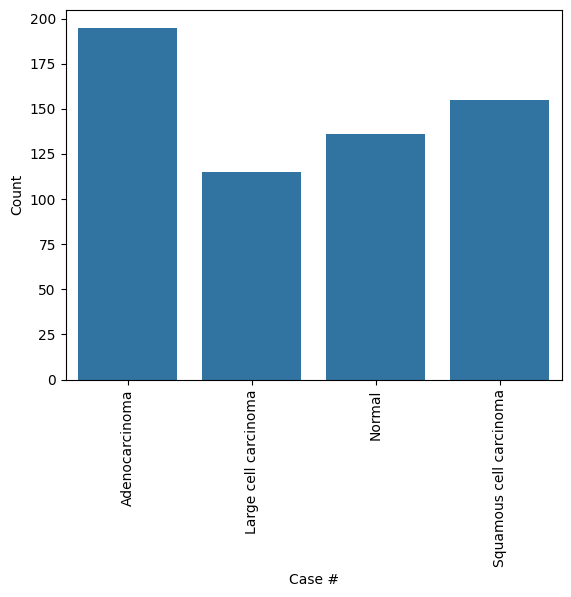

In [10]:
# Visualize the distribution of each Case
sns.countplot(x = "label", data = train_df)
plt.xticks(rotation=90)
plt.xlabel("Case #")
plt.ylabel("Count")
plt.show()

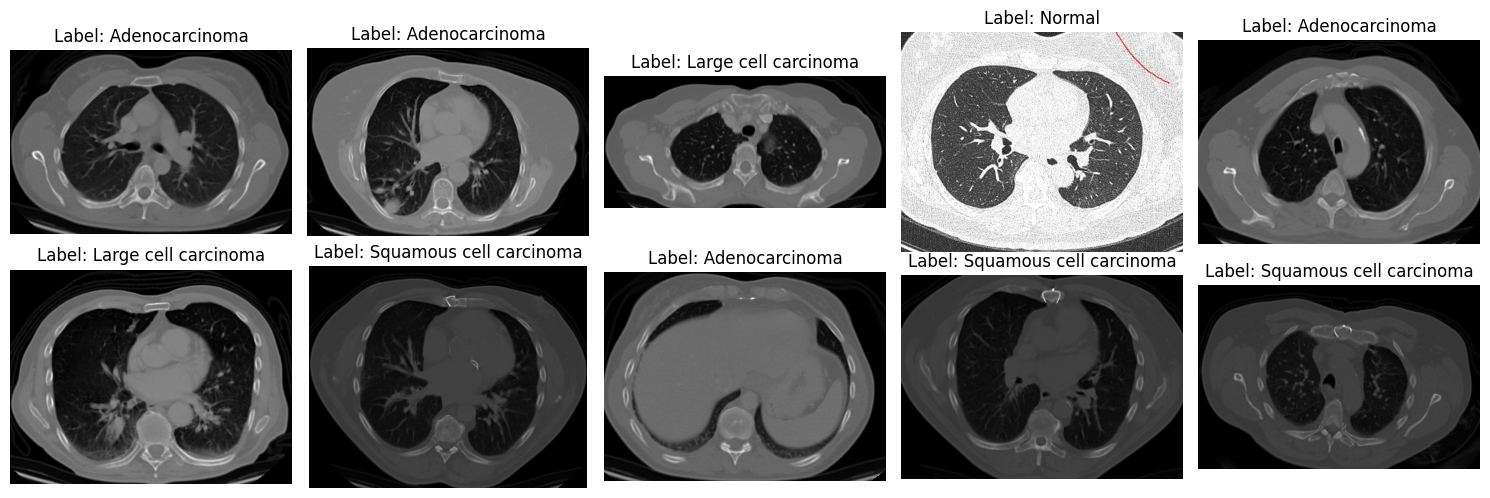

In [11]:
plot(train_df)

In [12]:
# Preprocess
from preprocess import preprocess_image, process_dataframe

In [13]:
label_encoder = LabelEncoder() # convert Label from categoricals labels to a number

# Train set
x_train, y_train = process_dataframe(train_df, label_encoder, fit_encoder=True)

# Validation and test sets (transform)
x_val, y_val = process_dataframe(val_df, label_encoder)
x_test, y_test = process_dataframe(test_df, label_encoder)

In [14]:
print(f"Number of Train examples: {len(x_test)}")
print(f"Number of Test examples: {len(x_test)}")
print(f"Number of Validation examples: {len(x_val)}")
print(f"Label classes: {label_encoder.classes_}")

Number of Train examples: 315
Number of Test examples: 315
Number of Validation examples: 72
Label classes: ['Adenocarcinoma' 'Large cell carcinoma' 'Normal'
 'Squamous cell carcinoma']


In [15]:
# Check some decoded labels
print("First 5 test labels (decoded):", label_encoder.inverse_transform(y_test[10:15]))
print("Corresponding filenames:", test_df["images"].iloc[10:15].values)

First 5 test labels (decoded): ['Normal' 'Adenocarcinoma' 'Squamous cell carcinoma' 'Adenocarcinoma'
 'Squamous cell carcinoma']
Corresponding filenames: [WindowsPath('Data/test/normal/6 - Copy (3).png')
 WindowsPath('Data/test/adenocarcinoma/000109 (4).png')
 WindowsPath('Data/test/squamous.cell.carcinoma/000125.png')
 WindowsPath('Data/test/adenocarcinoma/000133 (2).png')
 WindowsPath('Data/test/squamous.cell.carcinoma/000167 (2).png')]


In [16]:
IMAGE_SIZE = (224, 224, 3)
NUM_CLASSES = train_df["label"].nunique()

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import models

In [18]:
def vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = IMAGE_SIZE)
    base_model.trainable = False

    # define full model with unfreezed last layers
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    # compile model
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss = SparseCategoricalCrossentropy(),
                  optimizer = optimizer,
                  metrics = ["accuracy"])
    return model

In [ ]:
vgg_model = vgg_model()
# define erly stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = vgg_model.fit(
    x_train, y_train, batch_size=32,
    epochs=60,
    validation_data=(x_test, y_test),
    callbacks = [early_stop]
)

Epoch 1/60
 8/19 ━━━━━━━━━━━━━━━━━━━━ 1:38 9s/step - accuracy: 0.2642 - loss: 1.4693

In [ ]:
# 10 indices chosen randomly
indices = random.sample(range(len(x_val)), 10)

# Get the images and true labels
x_sample = x_val[indices]
y_true = y_val[indices]
    
def plot_predictions(model):
    # Predict labels
    y_pred_probs = model.predict(x_sample)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Decode labels using label_incoder
    actual_labels = label_encoder.inverse_transform(y_true)
    predicted_labels = label_encoder.inverse_transform(y_pred)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = cv2.cvtColor((x_sample[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)  # if images are normalized
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {actual_labels[i]}\nPred: {predicted_labels[i]}", fontsize=10, color='green' if actual_labels[i]==predicted_labels[i] else 'red')
    plt.tight_layout()
    plt.show()

In [ ]:
# CNN Model Predictions
plot_predictions(vgg_model)